In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
import random
from tqdm import tqdm
from multiprocessing import Pool, Manager
import os

In [2]:
path = '/content/lncrna_pseudo.csv'
df = pd.read_csv(path)
df.head()

,RNA_sequence_x,RNA_sequence_y,Category_x,Category_y,Category_Couple
0,GACUCGCUGUUCUCUUUGGCAAACCCUGGACAUUUCUUUUAGCGAU...,AAAGGCAAUUAGACCAUUGGGACCAUUUCCGACCUGGCGCCGCCAG...,pseudo,lncRNA,pseudo - lncRNA
1,GCAGUUCGGUUUAAGCUGGACUGCAGGCGGGCUCUUGGUGGCAAUG...,UUCUUUACCUUUCCGACACCAUUGCCCAGCCUGAGUAUUUGCACUU...,pseudo,lncRNA,pseudo - lncRNA
2,GCAGUUCGGUUUAAGCUGGACUGCAGGCGGGCUCUUGGUGGCAAUG...,UUCUUUACCUUUCCGACACCAUUGCCCAGCCUGAGUAUUUGCACUU...,pseudo,lncRNA,pseudo - lncRNA
3,AAAUCCCAACGGCUCCGGACGCCUGAAUGGAGCCUCGCUCCCUCUG...,GAGACGAUCCACUGGAAGGGCCUGGCUUGCGUCCAGAGUCGCCUCC...,lncRNA,pseudo,lncRNA - pseudo
4,AAAUCCCAACGGCUCCGGACGCCUGAAUGGAGCCUCGCUCCCUCUG...,GAGACGAUCCACUGGAAGGGCCUGGCUUGCGUCCAGAGUCGCCUCC...,lncRNA,pseudo,lncRNA - pseudo


Number of unique sequences: 1369


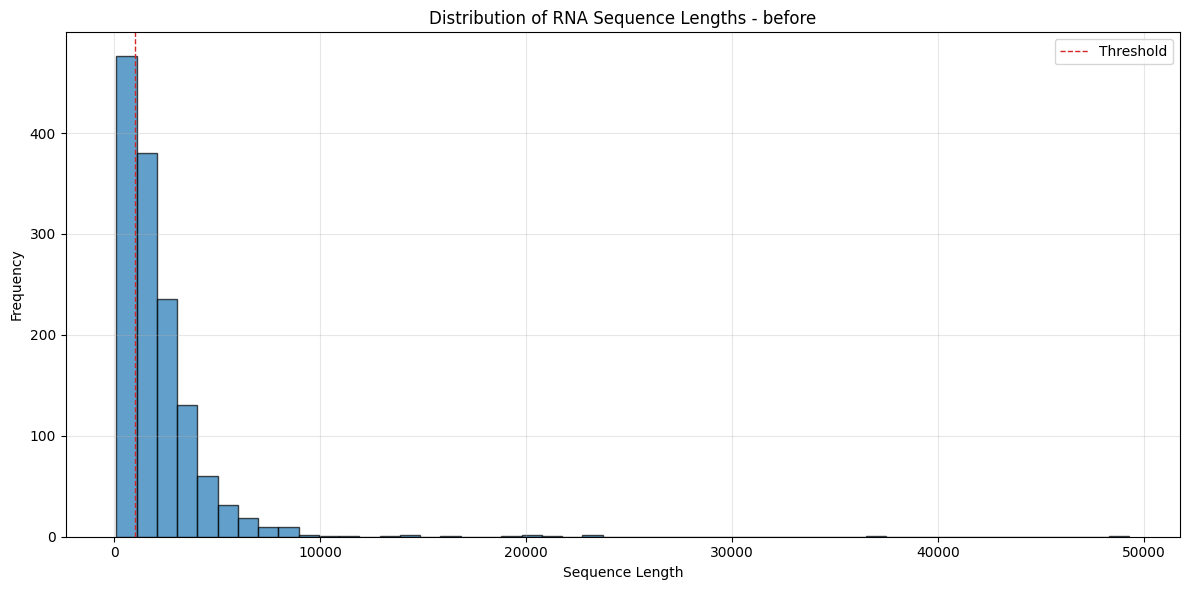

Count sequence couples: RNA_sequence_x     6967
RNA_sequence_y     6967
Category_x         6967
Category_y         6967
Category_Couple    6967
dtype: int64
Count after filtering sequences exceeding 1022: RNA_sequence_x     1085
RNA_sequence_y     1085
Category_x         1085
Category_y         1085
Category_Couple    1085
dtype: int64


In [3]:
# Step 1: Data analisys:
all_sequences = pd.concat([df['RNA_sequence_x'], df['RNA_sequence_y']]).unique()
num_unique_sequences = len(all_sequences)
print(f"Number of unique sequences: {num_unique_sequences}")

sequence_lengths = [len(seq) for seq in all_sequences]
plt.figure(figsize=(12, 6))
plt.hist(sequence_lengths, bins=50, edgecolor='black', alpha=0.7, color='tab:blue')
plt.axvline(x=1022, color='tab:red', linestyle='--', linewidth=1, label='Threshold')
plt.title('Distribution of RNA Sequence Lengths - before')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

print('Count sequence couples:', df.count())
filtered_df = df[
    df.apply(
        lambda row: len(row['RNA_sequence_x']) <= 1022 and len(row['RNA_sequence_y']) <= 1022, axis=1)
]
print('Count after filtering sequences exceeding 1022:', filtered_df.count())

Number of unique sequences: 131


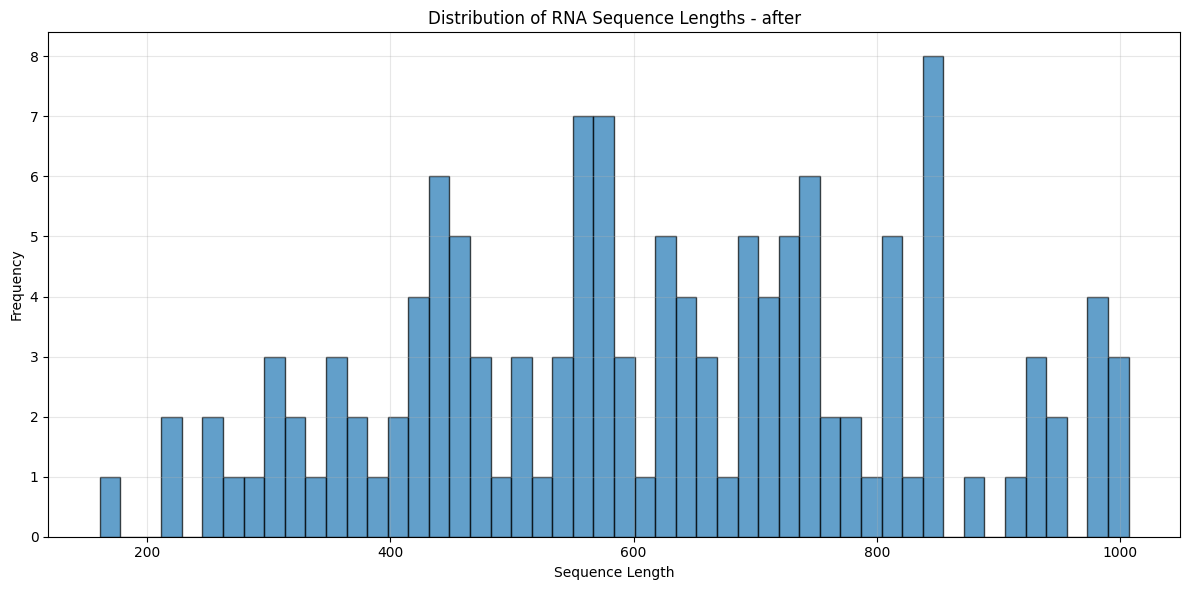

In [4]:
all_sequences = pd.concat([filtered_df['RNA_sequence_x'], filtered_df['RNA_sequence_y']]).unique()
num_unique_sequences = len(all_sequences)
print(f"Number of unique sequences: {num_unique_sequences}")
sequence_lengths = [len(seq) for seq in all_sequences]

plt.figure(figsize=(12, 6))
plt.hist(sequence_lengths, bins=50, edgecolor='black', alpha=0.7, color='tab:blue')
plt.title('Distribution of RNA Sequence Lengths - after')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [5]:
print("=== DATA CONNECTIVITY ANALYSIS ===")
print()
print(f"Total interaction pairs: {len(df)}")
print(f"Unique RNA sequences involved: {num_unique_sequences}")
all_seq_list = list(df['RNA_sequence_x']) + list(df['RNA_sequence_y'])
interaction_counts = Counter(all_seq_list)
print(f"Average interactions per RNA: {len(all_seq_list) / num_unique_sequences:.2f}")
print(f"Most connected RNA has {max(interaction_counts.values())} interactions")
print(f"RNAs with only 1 interaction: {sum(1 for c in interaction_counts.values() if c == 1)}")

=== DATA CONNECTIVITY ANALYSIS ===

Total interaction pairs: 6967
Unique RNA sequences involved: 131
Average interactions per RNA: 106.37
Most connected RNA has 3950 interactions
RNAs with only 1 interaction: 708



=== GRAPH NETWORK ANALYSIS ===
Number of nodes (unique RNA sequences): 131
Number of edges (interactions): 76
Graph density: 0.0089
Is connected: False
Number of connected components: 55
Largest component size: 18

Degree Statistics:
Average degree: 1.16
Median degree: 1
Max degree: 17
Min degree: 1

Nodes with degree 1: 125
Nodes with degree 2-5: 5
Nodes with degree > 10: 1


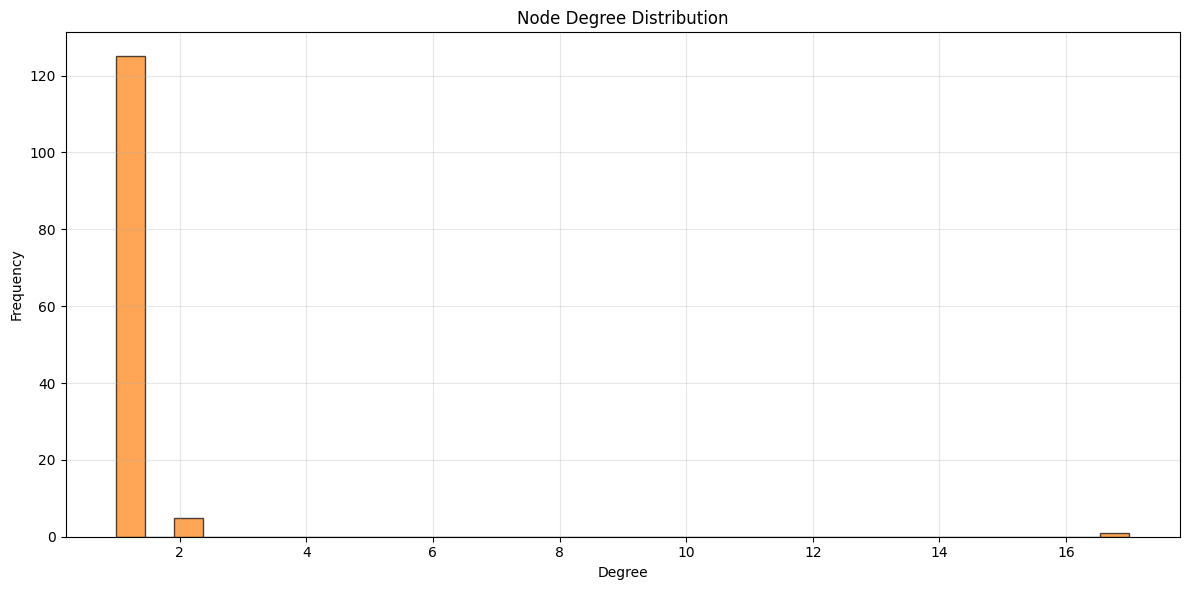

Visualizing complete network with 131 nodes and 76 edges


<Figure size 2000x1600 with 0 Axes>

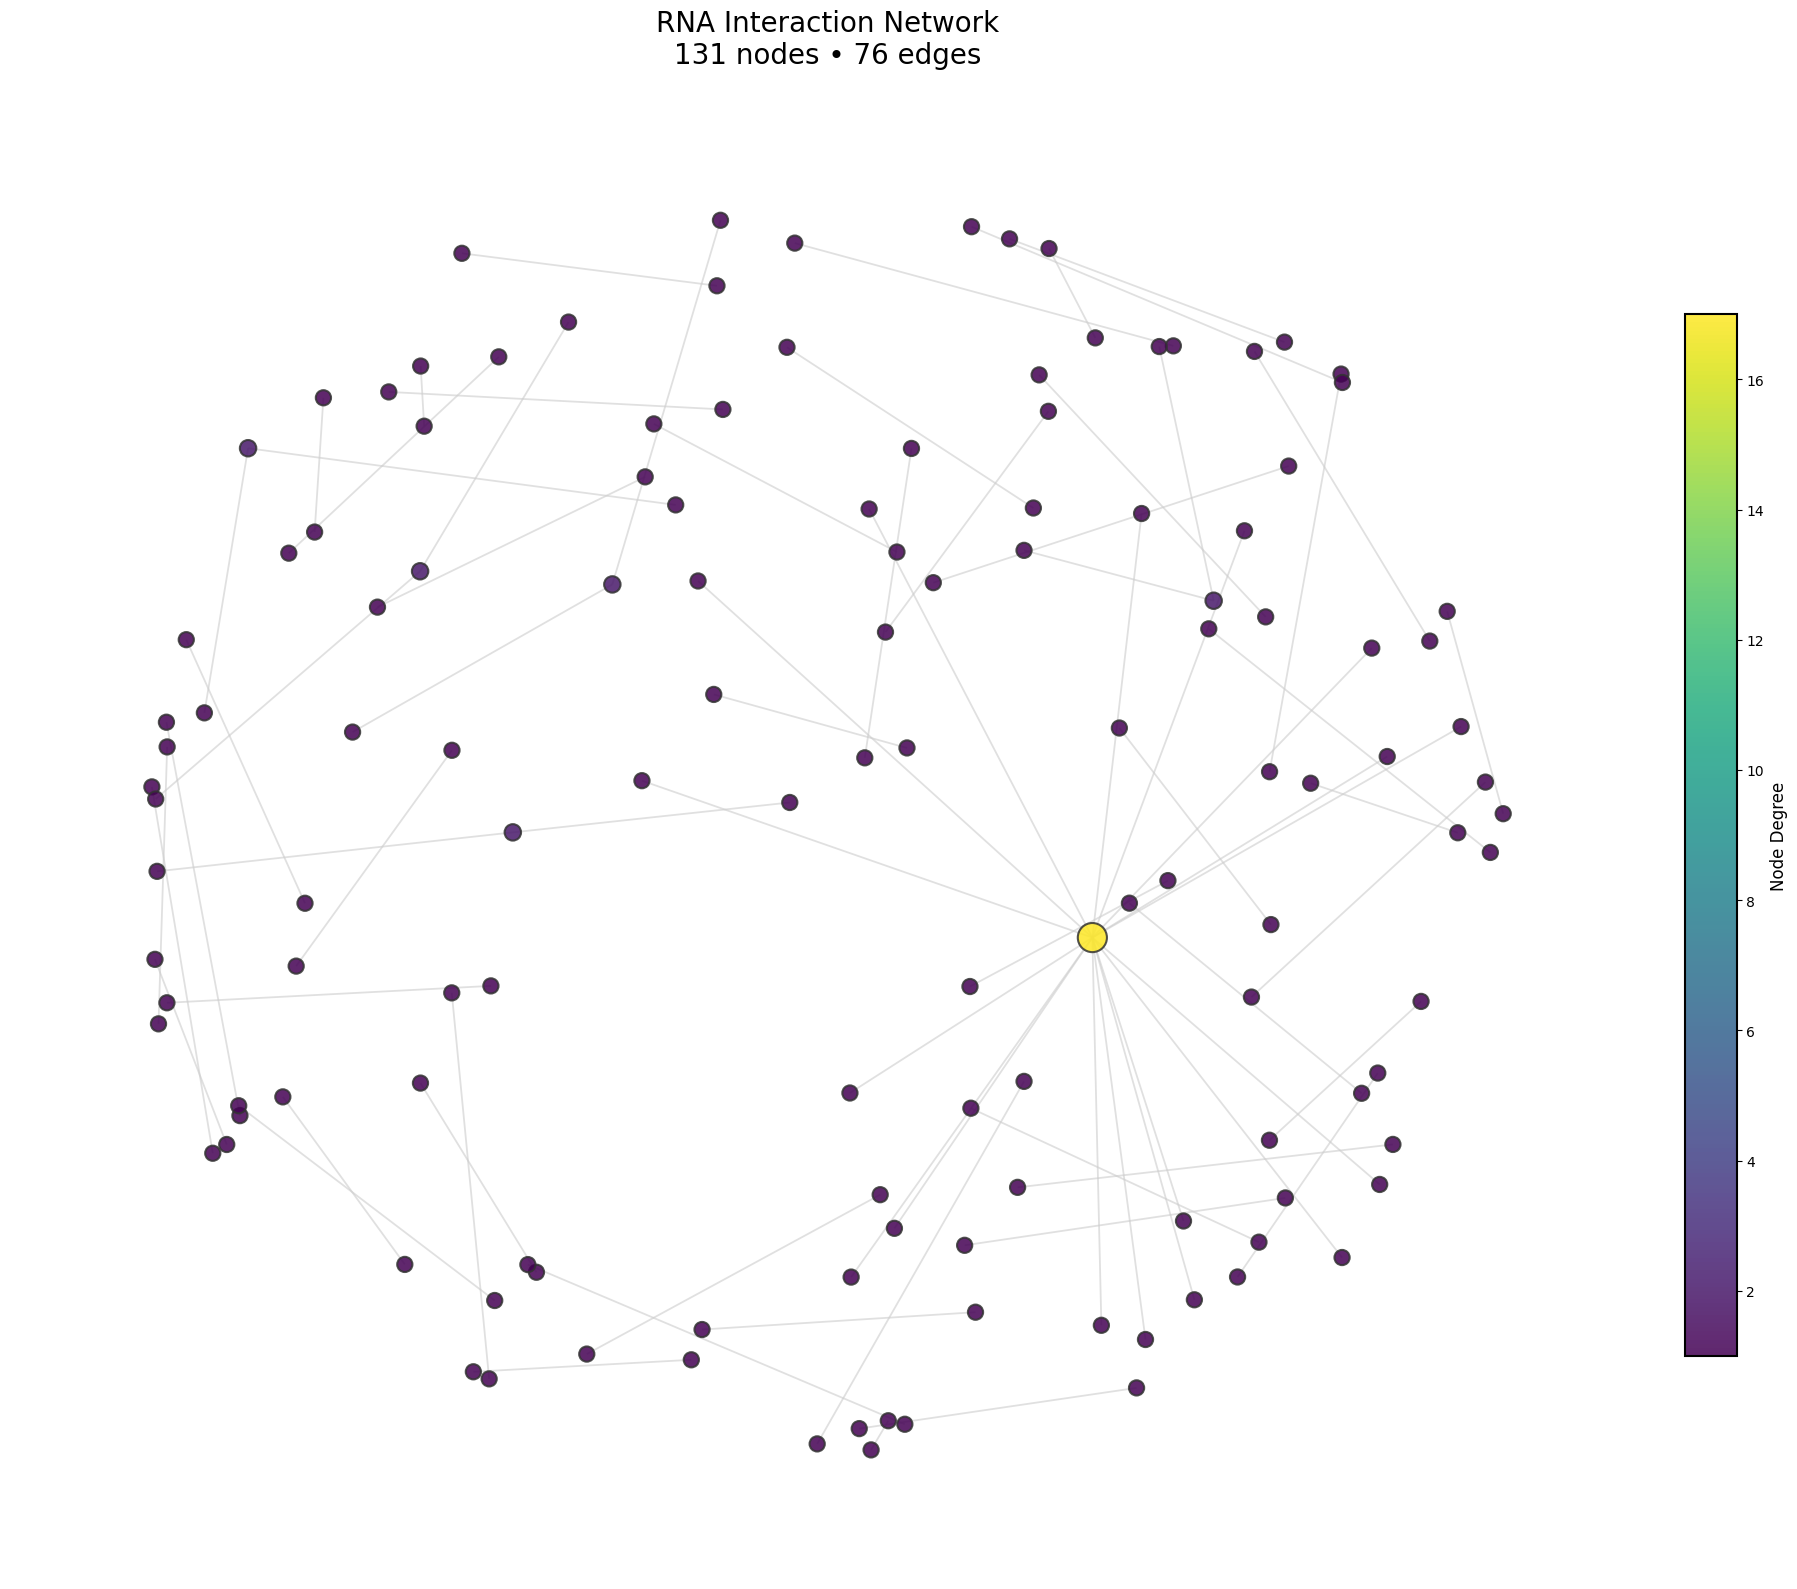


Top 10 Hub Nodes (by degree):
1. Degree 17: AGAUGUGUUUAUUUUGGAGCCUACACCAGCGCCUUUUUUGUUUGCUCUUU...
2. Degree 2: GGGGGAACUUGCCAAUCGUAUGCAGCCUCUUCUGUUAGCUUUAUUGUUCC...
3. Degree 2: CUCCCUGCCCAGAGCUUCUCUUCACUGACUGUCUGGGACAAGCCAGCGCC...
4. Degree 2: AUUCCCUUACUUUCUUAAUAAACUCGCUUUCACUUUAUGGAUUCAACUGU...
5. Degree 2: ACUCCGCUUGUGCUCUGGGAAGGAGAAGGGCGUGUUUCCGCUUGCUCCUC...
6. Degree 2: CGGGGAGACCGCGUUUAGAGGAUCAGUGGCGGCGGGCCCGCGCGGUGCCG...
7. Degree 1: AUGAAUGUGGAAACCCCAGCUGAUUUAACAAGGAAGUUGAGUGGCUUUCU...
8. Degree 1: GAGUUGGGGCCAAUAAUAAGCUGUUGUUUGAAGUCACUAAGCUUUCAGAU...
9. Degree 1: AUGGCGAAUGAGACCAGUGCAGUGGGAGGGCCUAGAGGCCCCAAAAUGGG...
10. Degree 1: AGAAGACCUCUGUUUCAAGUCUCUGGCUAACUAGCUAGGACAGGAGGUCU...


In [6]:
print("\n=== GRAPH NETWORK ANALYSIS ===")

# Create a graph from the filtered dataframe
G = nx.Graph()

# Add edges (interactions) between RNA sequences
for _, row in filtered_df.iterrows():
    seq_x = row['RNA_sequence_x']
    seq_y = row['RNA_sequence_y']
    G.add_edge(seq_x, seq_y)

# Basic graph statistics
print(f"Number of nodes (unique RNA sequences): {G.number_of_nodes()}")
print(f"Number of edges (interactions): {G.number_of_edges()}")
print(f"Graph density: {nx.density(G):.4f}")
print(f"Is connected: {nx.is_connected(G)}")

if not nx.is_connected(G):
    components = list(nx.connected_components(G))
    print(f"Number of connected components: {len(components)}")
    print(f"Largest component size: {len(max(components, key=len))}")

# Node degree analysis
degrees = dict(G.degree())
degree_values = list(degrees.values())

print(f"\nDegree Statistics:")
print(f"Average degree: {sum(degree_values) / len(degree_values):.2f}")
print(f"Median degree: {sorted(degree_values)[len(degree_values)//2]}")
print(f"Max degree: {max(degree_values)}")
print(f"Min degree: {min(degree_values)}")

# Degree distribution
degree_counts = Counter(degree_values)
print(f"\nNodes with degree 1: {degree_counts.get(1, 0)}")
print(f"Nodes with degree 2-5: {sum(degree_counts.get(i, 0) for i in range(2, 6))}")
print(f"Nodes with degree > 10: {sum(v for k, v in degree_counts.items() if k > 10)}")

# Plot degree distribution
plt.figure(figsize=(12, 6))
plt.hist(degree_values, bins=35, edgecolor='black', alpha=0.7, color='tab:orange', rwidth=1)
plt.title('Node Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


plt.figure(figsize=(20, 16))
# Use the complete graph
G_viz = G
print(f"Visualizing complete network with {G_viz.number_of_nodes()} nodes and {G_viz.number_of_edges()} edges")

# Calculate node sizes based on degree
node_degrees = dict(G_viz.degree())
node_sizes = [100 + 20 * node_degrees[node] for node in G_viz.nodes()]

node_colors = [node_degrees[node] for node in G_viz.nodes()]
pos = nx.spring_layout(G_viz, k=0.5, iterations=50, seed=42)
fig, ax = plt.subplots(figsize=(20, 16), facecolor='white')
ax.set_facecolor('white')

# Draw edges with softer appearance
nx.draw_networkx_edges(G_viz, pos,
                       alpha=0.6,
                       width=1.3,
                       edge_color='#cccccc',
                       ax=ax)

# Draw nodes with modern styling
nodes = nx.draw_networkx_nodes(G_viz, pos,
                       node_size=node_sizes,
                       node_color=node_colors,
                       cmap=plt.cm.viridis,
                       alpha=0.85,
                       linewidths=1.5,
                       edgecolors='#333333',
                       ax=ax)

# Add colorbar with styling
cbar = plt.colorbar(nodes, ax=ax, label='Node Degree', shrink=0.7, pad=0.02)
cbar.ax.yaxis.label.set_fontsize(12)
cbar.outline.set_linewidth(1.5)

plt.title(f'RNA Interaction Network\n{G_viz.number_of_nodes()} nodes • {G_viz.number_of_edges()} edges',
          fontsize=20, pad=20)

plt.axis('off')
plt.tight_layout()
plt.show()

# Identify hub nodes (highly connected RNAs)
print("\nTop 10 Hub Nodes (by degree):")
top_hubs = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]
for i, (node, degree) in enumerate(top_hubs, 1):
    node_preview = node[:50] + "..." if len(node) > 50 else node
    print(f"{i}. Degree {degree}: {node_preview}")

In [7]:
# Step 2: Train/test split

# Perform stratified train-test split
train_df, test_df = train_test_split(
    filtered_df,
    test_size=0.2,
    random_state=42
)

train_df.count()

,0
RNA_sequence_x,868
RNA_sequence_y,868
Category_x,868
Category_y,868
Category_Couple,868


In [8]:
test_df.count()

,0
RNA_sequence_x,217
RNA_sequence_y,217
Category_x,217
Category_y,217
Category_Couple,217


In [9]:
# Step 2: Data Augmentation.

# Function to flip a sequence
def flip_sequence(seq):
    return seq[::-1]

# Function to augment a row
def augment_row(row):
    augmented_rows = []

    # 1. Original row (as-is)
    augmented_rows.append(row.copy())

    # 2. Row with both RNA_sequence_x and RNA_sequence_y flipped
    flipped_both_row = row.copy()
    flipped_both_row['RNA_sequence_x'] = flip_sequence(row['RNA_sequence_x'])
    flipped_both_row['RNA_sequence_y'] = flip_sequence(row['RNA_sequence_y'])
    augmented_rows.append(flipped_both_row)

    # 3. Row with RNA_sequence_x and RNA_sequence_y swapped (and Category_x, Category_y)
    swapped_row = row.copy()
    swapped_row['RNA_sequence_x'], swapped_row['RNA_sequence_y'] = row['RNA_sequence_y'], row['RNA_sequence_x']
    swapped_row['Category_x'], swapped_row['Category_y'] = row['Category_y'], row['Category_x']
    augmented_rows.append(swapped_row)

    # 4. Swapped and flipped both RNA_sequence_x and RNA_sequence_y
    swapped_flipped_both_row = swapped_row.copy()
    swapped_flipped_both_row['RNA_sequence_x'] = flip_sequence(swapped_row['RNA_sequence_x'])
    swapped_flipped_both_row['RNA_sequence_y'] = flip_sequence(swapped_row['RNA_sequence_y'])
    augmented_rows.append(swapped_flipped_both_row)

    return augmented_rows

# Function to perform data augmentation on the entire dataframe
def augment_dataframe(df):
    augmented_data = []
    for _, row in df.iterrows():
        augmented_data.extend(augment_row(row))
    return pd.DataFrame(augmented_data)

# Apply data augmentation on both the training and testing sets
augmented_train_df = augment_dataframe(train_df)
augmented_test_df = augment_dataframe(test_df)
train_df_noaug = train_df
test_df_noaug = test_df
# Print the number of rows in the augmented sets
print(f"Augmented training set size: {len(augmented_train_df)}")
print(f"Augmented testing set size: {len(augmented_test_df)}")
print(f"not Augmented train set size: {len(train_df_noaug)}")
print(f"not Augmented test set size: {len(test_df_noaug)}")

train_df = augmented_train_df
test_df = augmented_test_df

# Shuffle the training DataFrame
train_df_shuffled = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Shuffle the test DataFrame
test_df_shuffled = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

train_df_noauf = train_df_noaug.sample(frac=1, random_state=42).reset_index(drop=True)

test_df_noauf = test_df_noaug.sample(frac=1, random_state=42).reset_index(drop=True)

Augmented training set size: 3472
Augmented testing set size: 868
not Augmented train set size: 868
not Augmented test set size: 217


In [10]:
# Step 3: Negatives generation.
def load_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)

def flip_sequence(seq):
    return seq[::-1]


# ----------------------------
# negative sampling
# ----------------------------
def worker_task_type_aware(positives_chunk, true_pairs_set, candidates, neg_ratio):
    sampled_pairs = []
    for seq_x in positives_chunk:
        for _ in range(neg_ratio):
            success = False
            for _retry in range(100):  # max 100 retries
                seq_y = random.choice(candidates) # SAMPLE ONE UNIQUE SEQ. from candidates
                pair_frozen = frozenset((seq_x, seq_y))
                # ensure uniqueness and exclusion of positives
                if (pair_frozen not in true_pairs_set and
                        pair_frozen not in map(frozenset, sampled_pairs)):
                    sampled_pairs.append((seq_x, seq_y))
                    success = True
                    break
            if not success:
                continue  # skip if no valid negative found
    return sampled_pairs

def sample_negatives(pos_pairs, elements,
                     neg_ratio=20, num_workers=10):

    # true positive pairs + flipped/special cases
    true_pairs_set = set(frozenset(p) for p in pos_pairs)
    special_cases = set()
    for a, b in pos_pairs:
        a_f, b_f = flip_sequence(a), flip_sequence(b)
        special_cases.update({
            frozenset((a, a)), frozenset((b, b)),
            frozenset((a_f, a_f)), frozenset((b_f, b_f)),
            frozenset((a, b_f)), frozenset((b, a_f)),
            frozenset((a, a_f)), frozenset((b, b_f))
        })
    true_pairs_set.update(special_cases)
    # split positives across workers
    positives = [a for a, _ in pos_pairs]
    chunk_size = max(1, len(positives) // num_workers)
    chunks = [positives[i:i + chunk_size] for i in range(0, len(positives), chunk_size)]
    sampled_negatives = []
    with Pool(processes=num_workers) as pool:
        async_results = [
            pool.apply_async(worker_task_type_aware,
                             args=(chunk, true_pairs_set, elements, neg_ratio))
            for chunk in chunks
        ]
        for ar in tqdm(async_results, desc="Sampling negatives"):
            sampled_negatives.extend(ar.get())
    # remove duplicates
    sampled_negatives = list(dict.fromkeys(sampled_negatives))

    # Remove duplicates while treating (A, B) as different from (B, A)
    sampled_negatives = list(set(sampled_negatives))

    return sampled_negatives


# ----------------------------
# Cross-validation preparation (main) - but single fold
# ----------------------------
def prepare_cv_data(folds,
                    random_state=42,
                    neg_ratio=21,
                    num_workers=10):
    """
    Returns folds: list of dicts. Each dict:
      { "train": {"positives": [( (s1,s2),(t1,t2) ), ...], "negatives": [...]},
        "test":  {...} }
    """

    # ----------------------------
    # Convert DataFrame to tuple format
    # ----------------------------
    def attach_pairs_with_types(instances):
        out = []
        if isinstance(instances, pd.DataFrame):
            iter_rows = instances.iterrows()
            for _, row in iter_rows:
                seq1 = row["RNA_sequence_x"]
                seq2 = row["RNA_sequence_y"]
                t1 = 'RNA'
                t2 = 'RNA'
                out.append([(seq1, seq2), (t1, t2)])
        elif isinstance(instances, list):
            for row in instances:
                if isinstance(row, dict):  # dict case
                    seq1 = row.get("RNA_sequence_x")
                    seq2 = row.get("RNA_sequence_y")
                    t1 = 'RNA'
                    t2 = 'RNA'
                elif isinstance(row, tuple):  # tuple (seq1, seq2)
                    seq1, seq2 = row
                    t1 = 'RNA'
                    t2 = 'RNA'
                else:
                    raise TypeError(f"Unsupported row type: {type(row)}")
                out.append([(seq1, seq2), (t1, t2)])
        else:
            raise TypeError(f"Unsupported instances type: {type(instances)}")
        return out

    # ----------------------------
    # K-fold negative sampling
    # ----------------------------

    folds_data = []

    for fold in folds:

        train_pos_aug = fold["train"]
        test_pos_aug = fold["test"]

        # ----------------------------
        # Split-specific candidate sequences
        # ----------------------------
        train_candidates = pd.unique(train_pos_aug[['RNA_sequence_x','RNA_sequence_y']].values.ravel())
        test_candidates = pd.unique(test_pos_aug[['RNA_sequence_x','RNA_sequence_y']].values.ravel())

        train_pairs = list(zip(train_pos_aug["RNA_sequence_x"], train_pos_aug["RNA_sequence_y"]))
        test_pairs  = list(zip(test_pos_aug["RNA_sequence_x"], test_pos_aug["RNA_sequence_y"]))

        # Negatives sampling
        train_negs = sample_negatives(train_pairs, train_candidates,
                                      neg_ratio=neg_ratio)
        test_negs = sample_negatives(test_pairs, test_candidates,
                                     neg_ratio=neg_ratio)


        folds_data.append({
            "train": {
                "positives": attach_pairs_with_types(train_pos_aug),
                "negatives": attach_pairs_with_types(train_negs),
            },
            "test": {
                "positives": attach_pairs_with_types(test_pos_aug),
                "negatives": attach_pairs_with_types(test_negs),
            },
        })

    return folds_data

In [11]:
# from test_df, train_df create the folds structure with a single fold
# to match the data structure prepare_cv_data needs:

folds = [{"train": train_df, "test": test_df}]

neg_ratio = 20 # negatives per positive,

folds = prepare_cv_data(folds, random_state=42, neg_ratio=neg_ratio)

print(f"Prepared {len(folds)} folds. Example fold sizes:")
for i, f in enumerate(folds):
    print(f" Fold {i}: train_pos={len(f['train']['positives'])}, train_neg={len(f['train']['negatives'])}, "
          f"test_pos={len(f['test']['positives'])}, test_neg={len(f['test']['negatives'])}")

# optional: save per-fold pickles for quicker per-fold loading/inspection
out_dir = f"folds_lncrna_pseudo"
os.makedirs(out_dir, exist_ok=True)
for i, f in enumerate(folds):
    per_path = os.path.join(out_dir, f"fold_{i}.pkl")
    with open(per_path, "wb") as fh:
        pickle.dump(f, fh, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Saved individual fold pickles -> {out_dir}/")

Sampling negatives: 100%|██████████| 11/11 [00:15<00:00,  1.44s/it]


Prepared 1 folds. Example fold sizes:
 Fold 0: train_pos=3472, train_neg=15614, test_pos=868, test_neg=5337
Saved individual fold pickles -> folds_lncrna_pseudo/


In [12]:
# Step 4: We need a list of all the possible unique seqeunces RNA-FM
# Considering data augmentation we must have a list of
# unique sequences PLUS a list of this sequences Flipped (read from the end to the beginning).
# NOTE: save this fasta file! download it!

# Generate a list of unique sequences and their flipped versions
all_sequences_and_flipped = list(all_sequences) + [flip_sequence(seq) for seq in all_sequences]
unique_sequences_and_flipped = list(set(all_sequences_and_flipped))
# Function to save sequences to a FASTA file
def save_to_fasta(sequences, filename):
    with open(filename, "w") as f:
        for i, seq in enumerate(sequences):
            f.write(f">sequence_{i+1}\n{seq}\n")

# Save the unique sequences and their flipped versions to a FASTA file
fasta_filename = "unique_sequences_with_flipped_lncrna_pseudo.fasta"
save_to_fasta(unique_sequences_and_flipped, fasta_filename)

print(f"Saved {len(unique_sequences_and_flipped)} unique sequences (including flipped) to {fasta_filename}")

Saved 262 unique sequences (including flipped) to unique_sequences_with_flipped_lncrna_pseudo.fasta
